In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge,LassoCV, Lasso, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_validate #Additional scklearn functions
from sklearn.model_selection import cross_val_score
from matplotlib.pylab import rcParams

In [2]:
df=pd.read_csv("concrete.csv")
df.dtypes ,  df.shape

(cement          float64
 slag            float64
 ash             float64
 water           float64
 superplastic    float64
 coarseagg       float64
 fineagg         float64
 age               int64
 strength        float64
 dtype: object,
 (1030, 9))

In [3]:
df.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

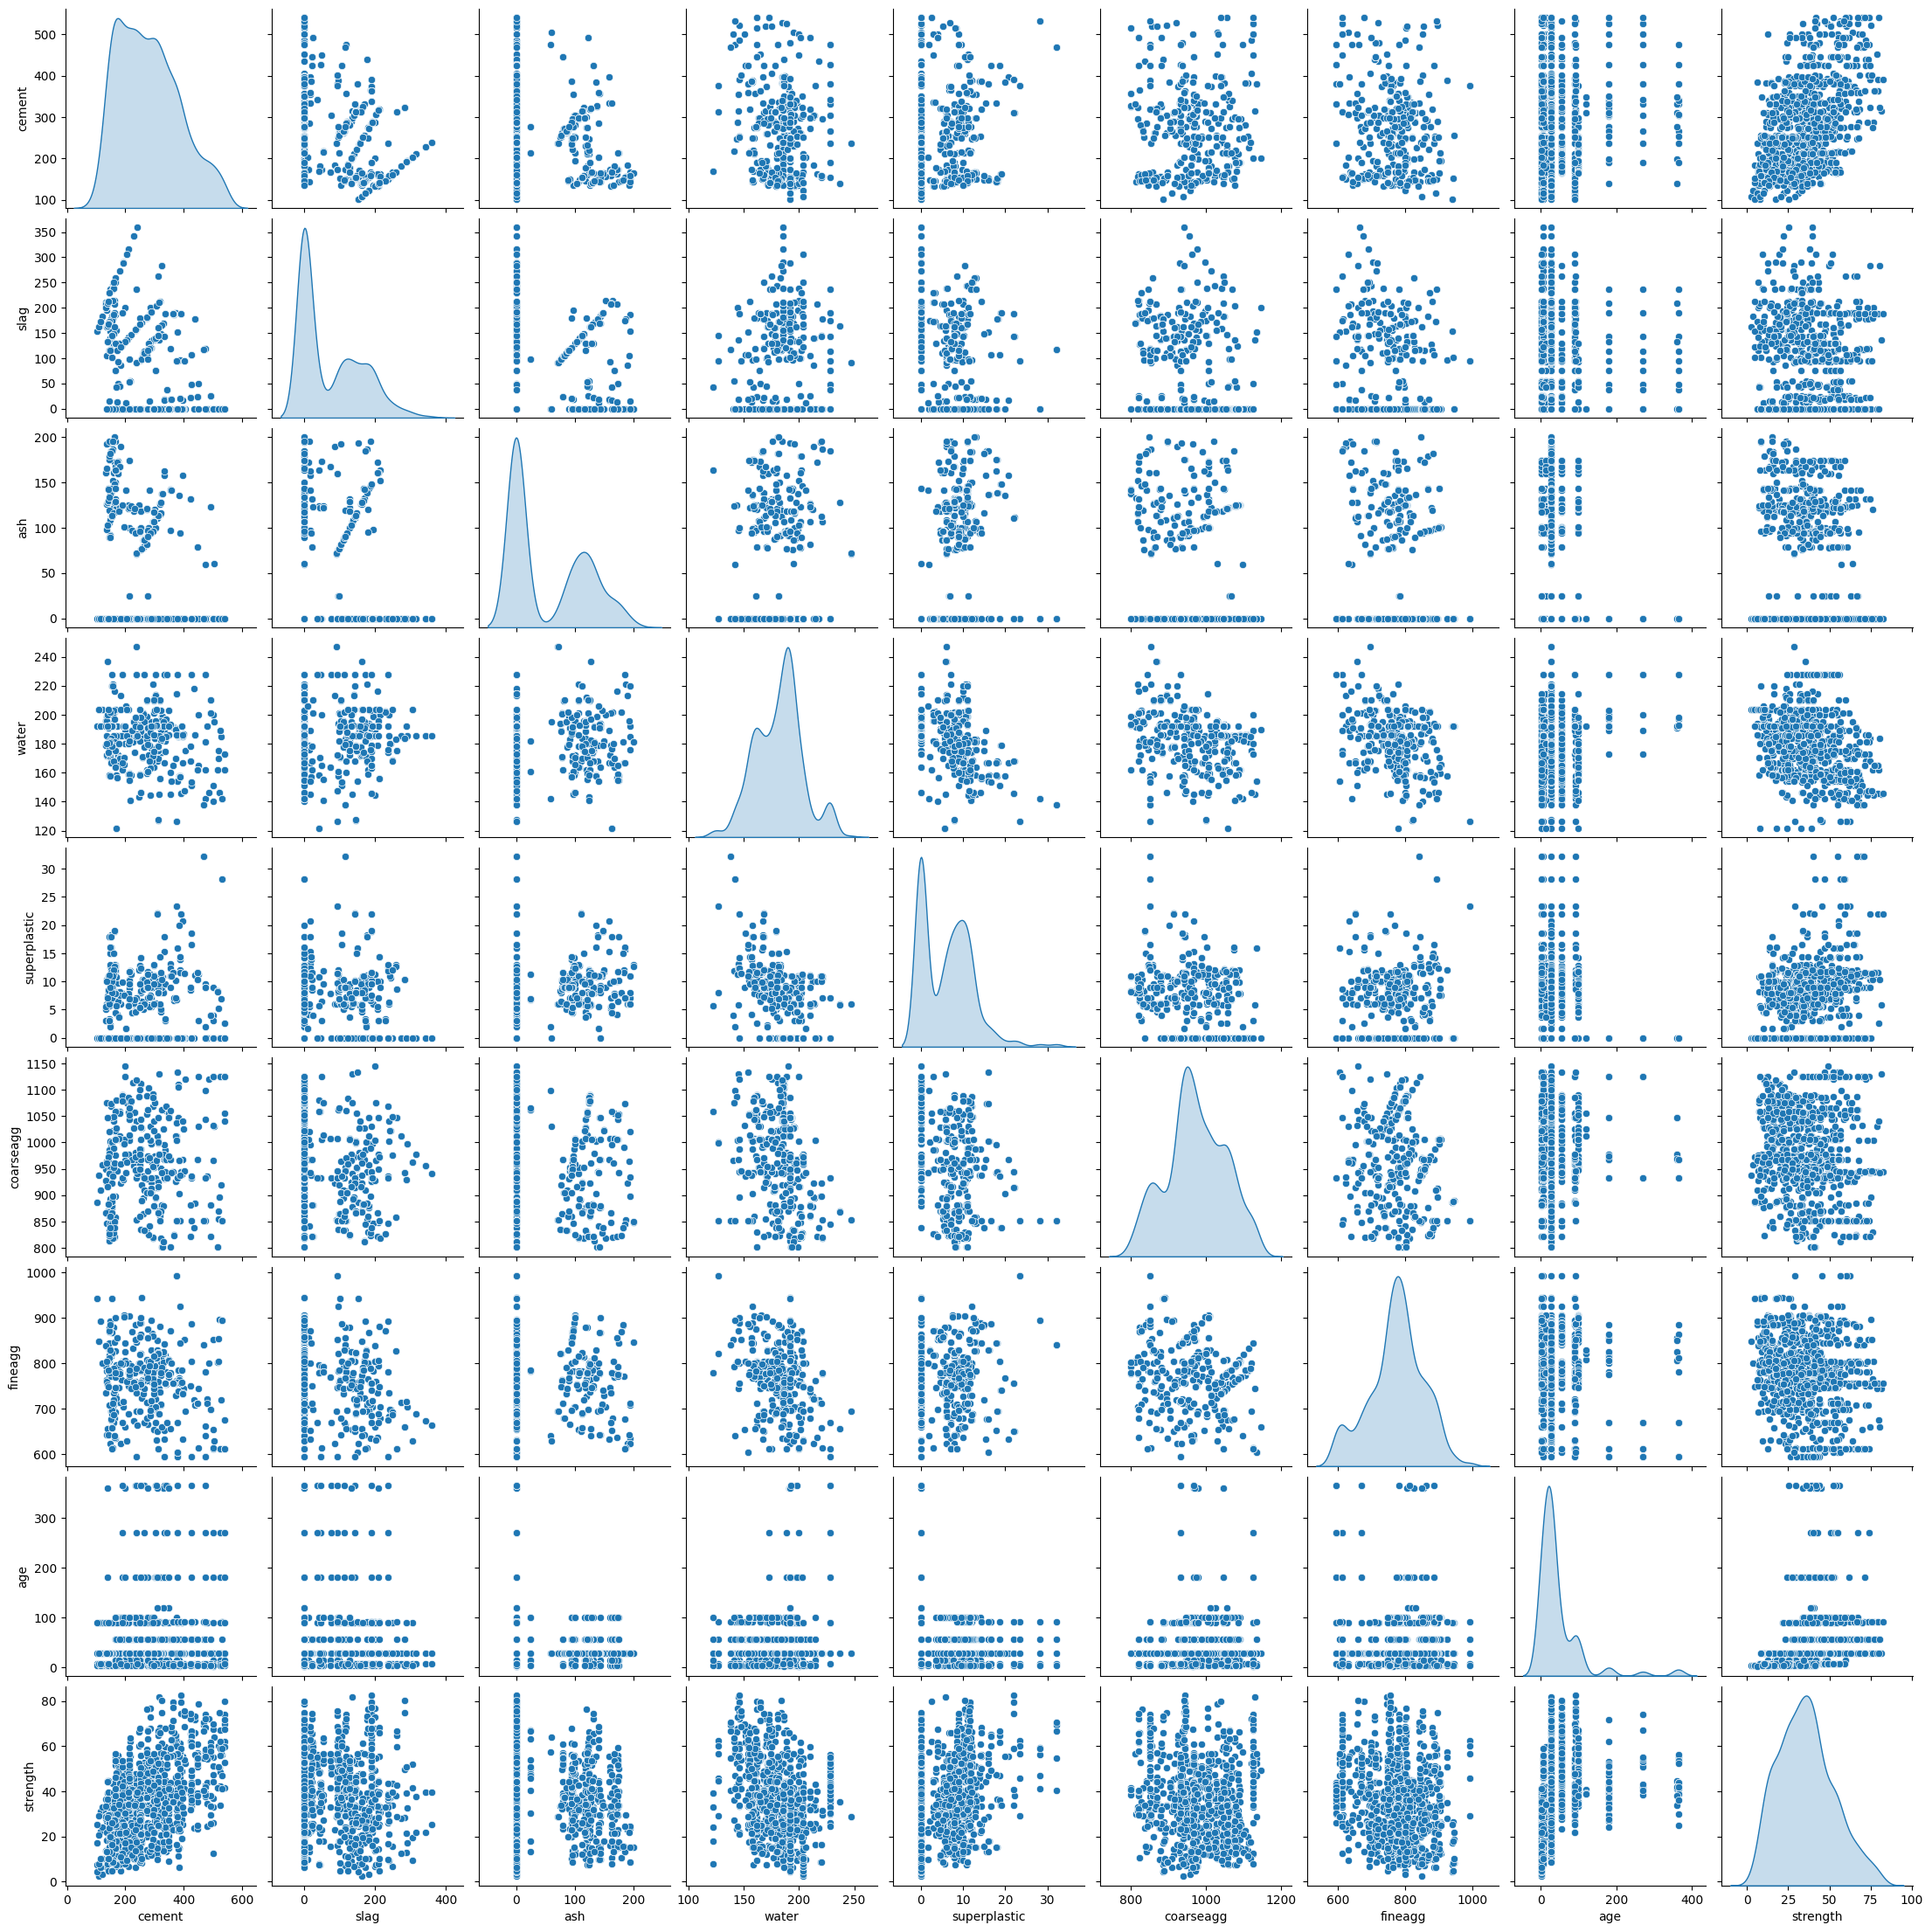

In [4]:
sns.pairplot(df, diag_kind='kde')

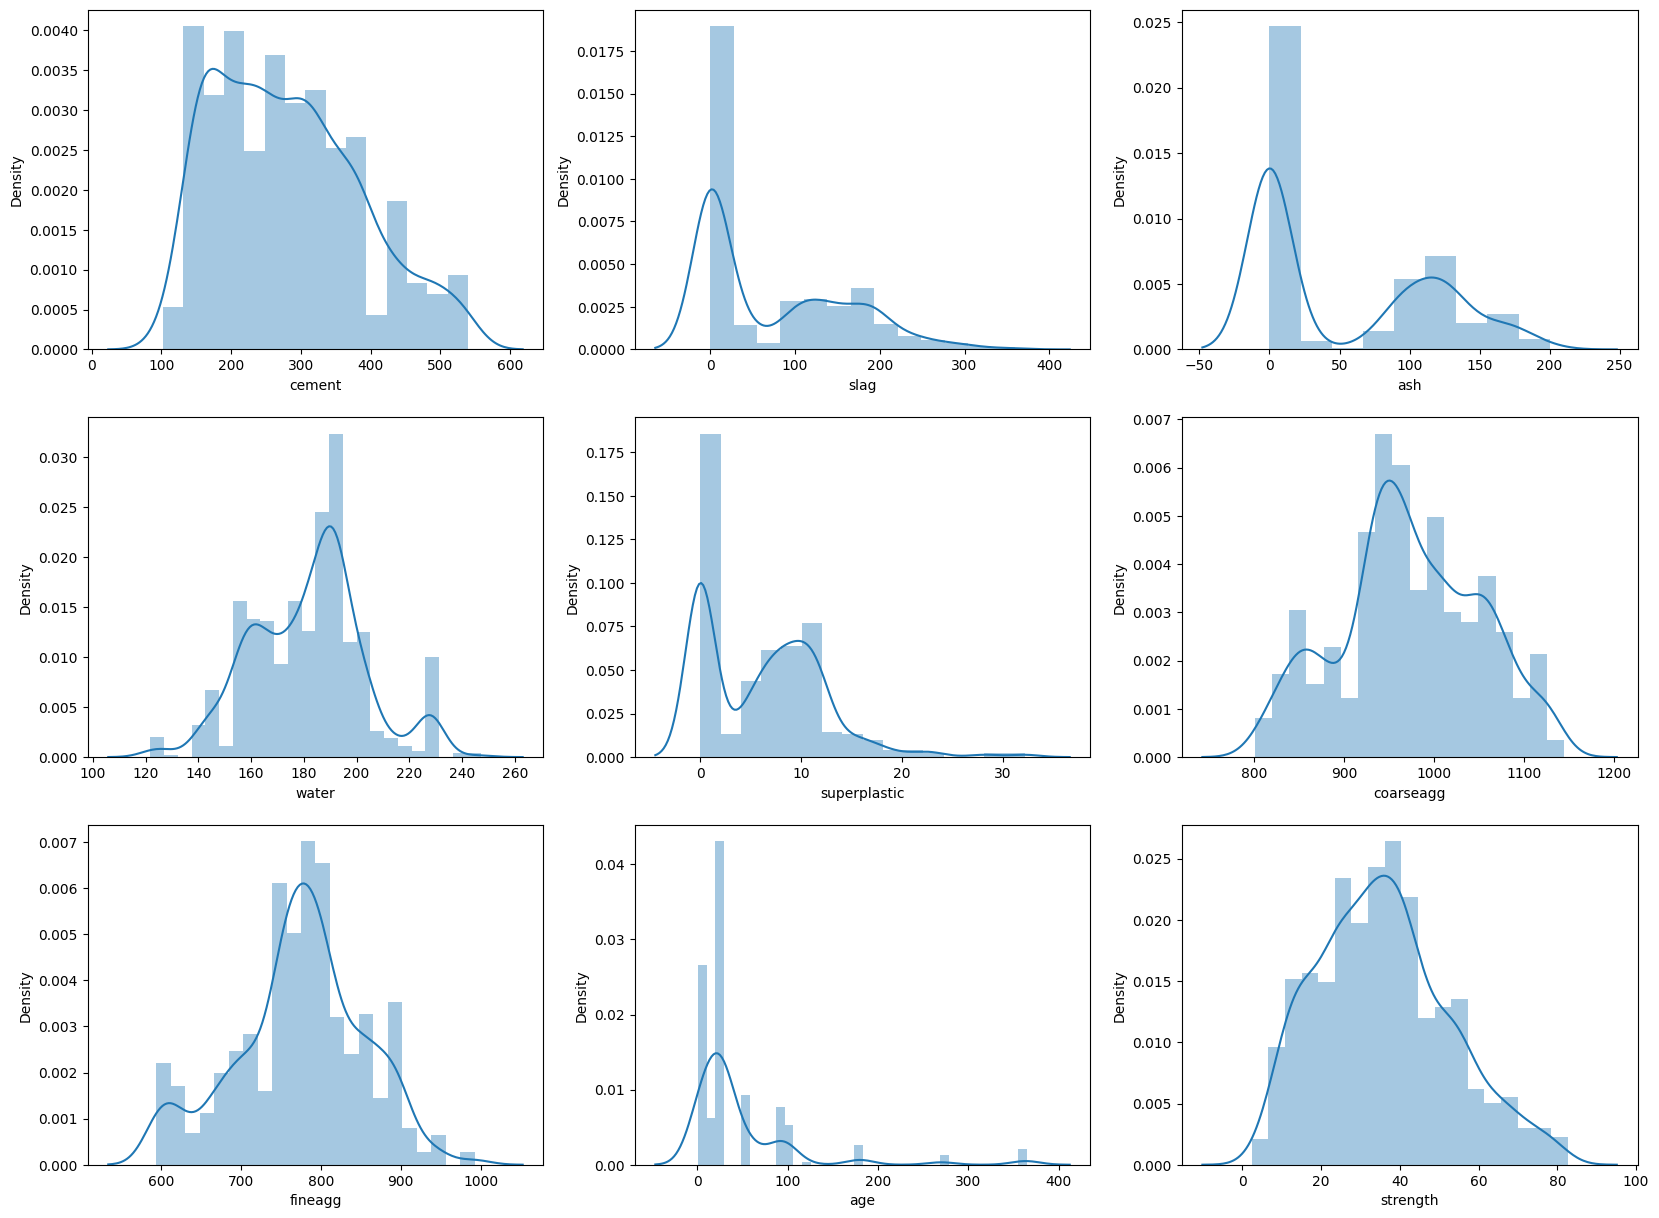

In [5]:
var=np.arange(1,len(df.columns)+1)
var
from IPython.core.pylabtools import figsize
figsize(20, 15)
for i in var:
    plt.subplot(3,3,i)
    sns.distplot(df.iloc[:,(i-1)])

some of the variables (super elastic,ash,superelastic)are displaying bi-modal distributions. Can explore adding a new variable for clustering.

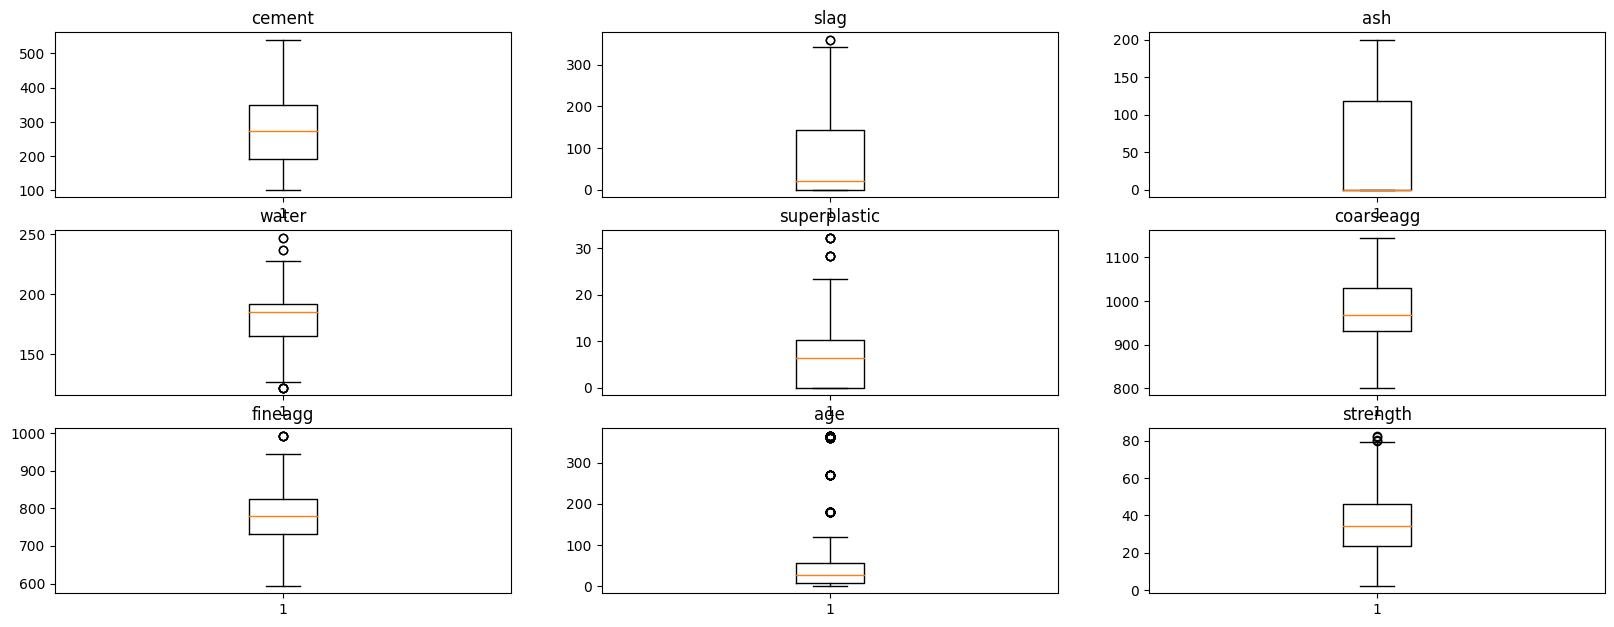

In [6]:
# Check for outliers
figsize(20, 15)
for i in var:
    plt.subplot(6,3,i)
    plt.boxplot(df.iloc[:,(i-1)])
    plt.title(df.columns[i-1])

A few variables a have some outliers. There are various methods of treating outliers. In this case, I am capping the outliers to the maximum possible value that is not an outlier.

In [7]:
Q1=np.percentile(df['slag'],25)
Q3=np.percentile(df['slag'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.slag=np.where(df.slag>UL, UL, df.slag)

In [8]:
Q1=np.percentile(df['fineagg'],25)
Q3=np.percentile(df['fineagg'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.fineagg=np.where(df.fineagg>UL, UL, df.fineagg)

In [9]:
Q1=np.percentile(df['water'],25)
Q3=np.percentile(df['water'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.water=np.where(df.water>UL, UL, df.water)

In [10]:
Q1=np.percentile(df['age'],25)
Q3=np.percentile(df['age'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.age=np.where(df.age>UL, UL, df.age)

In [11]:
Q1=np.percentile(df['superplastic'],25)
Q3=np.percentile(df['superplastic'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.superplastic=np.where(df.superplastic>UL, UL, df.superplastic)

<Axes: >

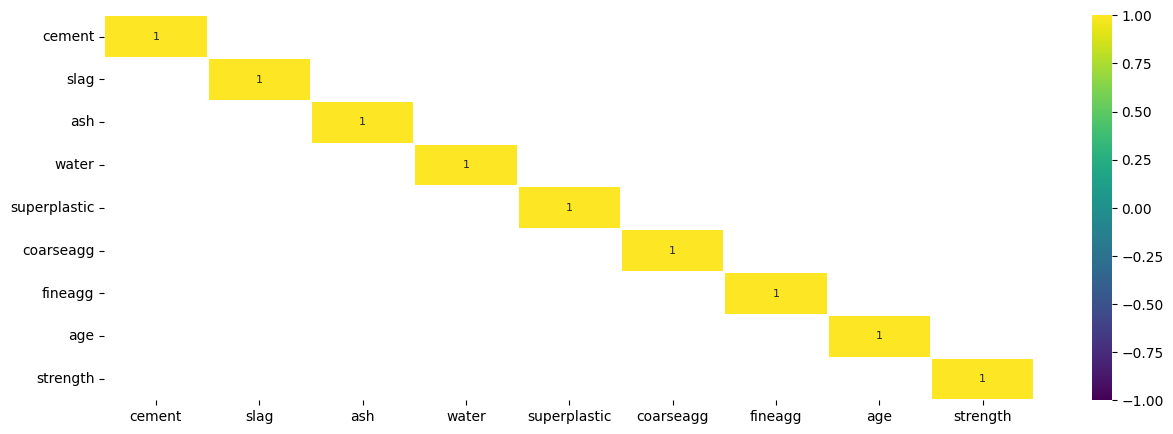

In [12]:
corr=df.corr()
plt.figure(figsize=(15, 5))
sns.heatmap(corr[(corr >= 0.70) | (corr <= -0.70)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8})

In [13]:
#no major correlations amongst the variables and hence no multicollinearity expected to affect the performance of models

In [14]:
from sklearn.cluster import KMeans

In [15]:
cl=np.arange(1,9)
ess=[]
for i in cl:
    clust=KMeans(n_init=15,n_clusters=i)
    clust.fit(df.iloc[:,0:8])
    error=clust.inertia_
    ess.append(error)

<Axes: xlabel='clusters', ylabel='errors'>

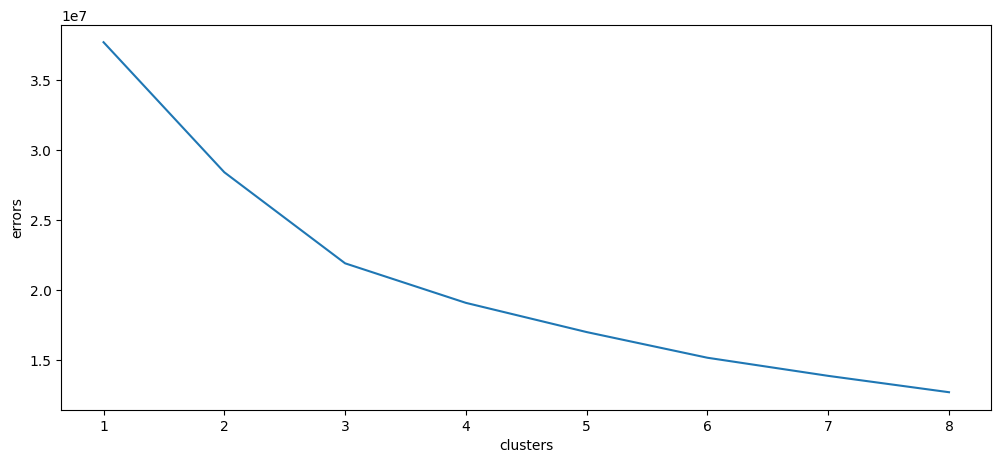

In [55]:
a=pd.DataFrame({'clusters':cl, 'errors':ess})
plt.figure(figsize=(12,5))
sns.lineplot(x=a.clusters, y=a.errors)


In [56]:
#elbow seen at 3 clusters
clust=KMeans(n_init=15, n_clusters=3)
clust.fit(df.iloc[:,0:8])
df['cluster']=clust.predict(df.iloc[:,0:8])
df.cluster=pd.Categorical(df.cluster)

In [57]:
df.cluster.value_counts() , df.columns

(cluster
 2    352
 0    341
 1    337
 Name: count, dtype: int64,
 Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
        'fineagg', 'age', 'strength', 'cluster'],
       dtype='object'))

In [58]:
X=df.iloc[:,[0,1,2,3,4,5,6,7,9]].values
y=df.strength.values

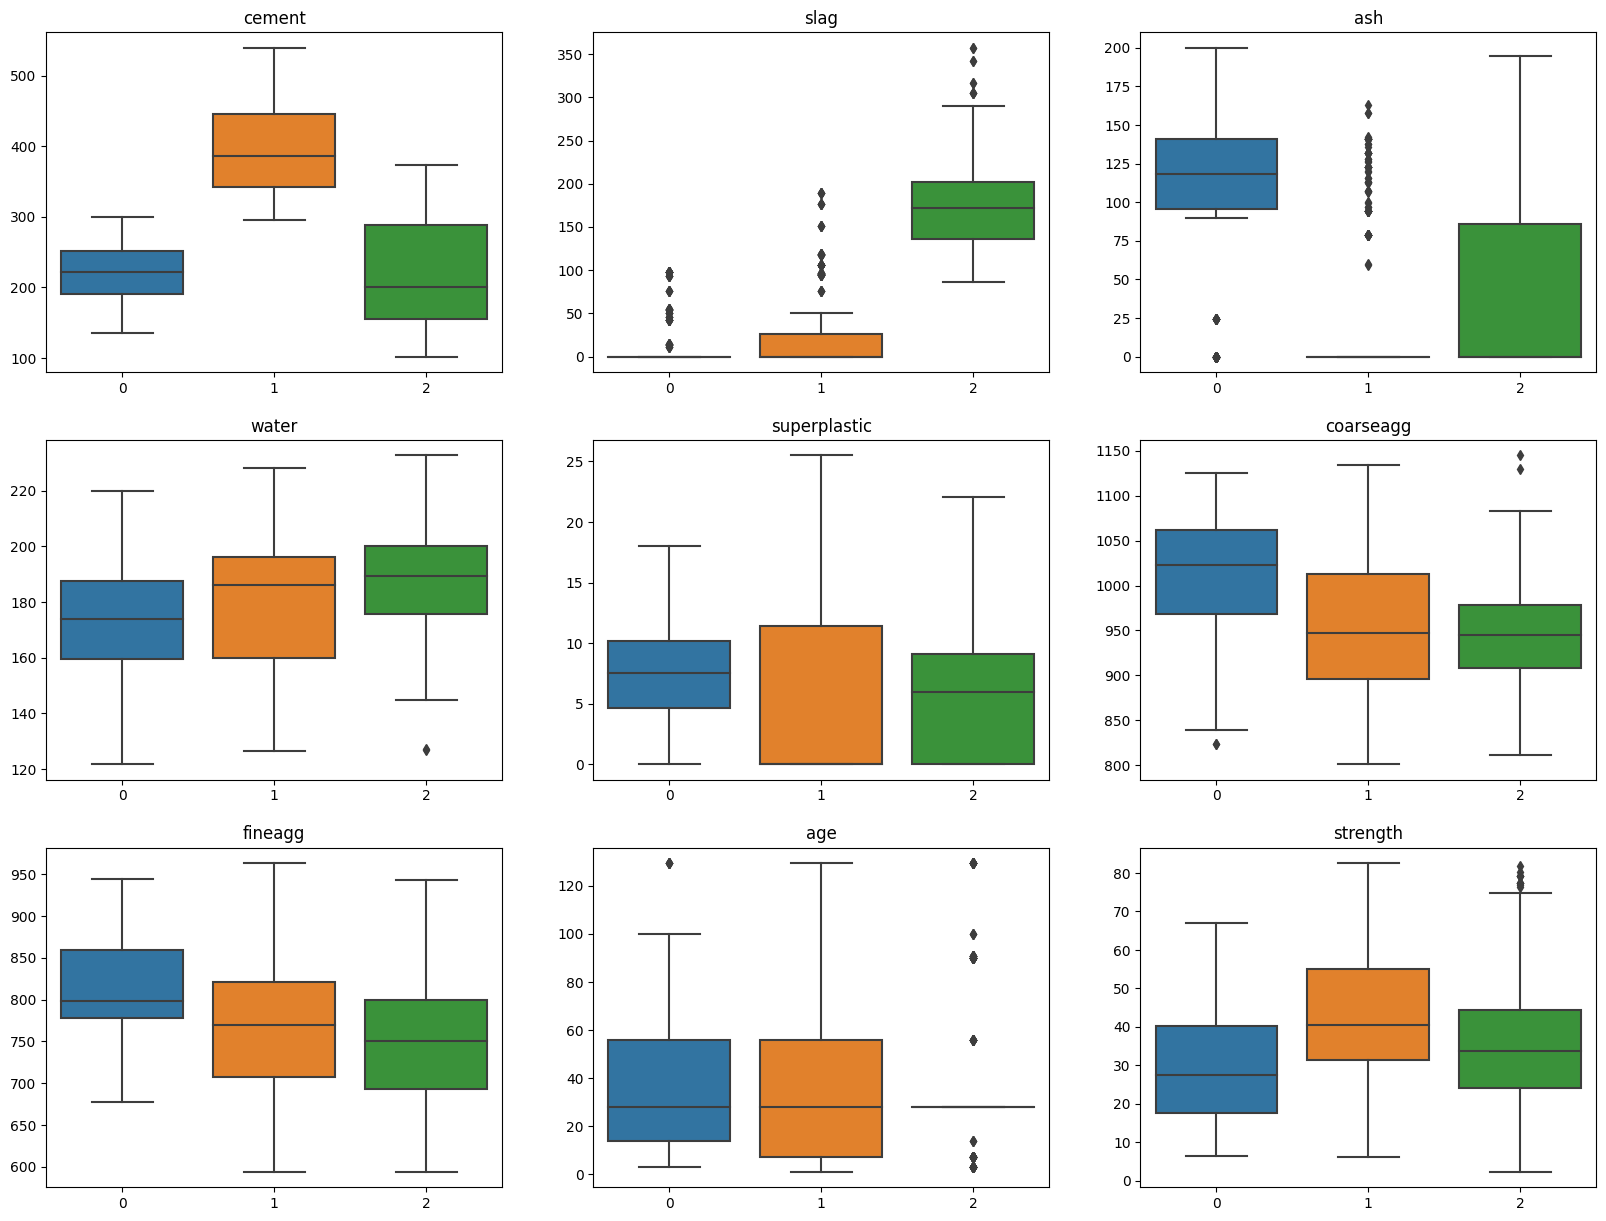

In [60]:
var=np.arange(1,len(df.columns))
var
from IPython.core.pylabtools import figsize
figsize(20, 15)
for i in var:
    plt.subplot(3,3,i)
    sns.boxplot(x=df.iloc[:,9], y=df.iloc[:,(i-1)])
    plt.xlabel("")
    plt.ylabel("")
    plt.title(df.columns[i-1])

# There seems to be three distinct clusters, especially when we see the distribution for strength of cement.

There are a few more outliers when the distribution seen for each cluster which we may or may not want to treat depending on our model performances. We check below the performance of models with addition of the new variable i.e. cluster

In [61]:
X = df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 9]].values
y = df.strength.values

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)

In [63]:
k=len(df.columns)-1
n_valid=len(X_valid)
n_test=len(X_test)

In [64]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [65]:
def test(models, X,y, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2)
            r2_test.append(r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

In [66]:
models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge()}

test(models, X,y)

,OLS,Lasso,Ridge
0,0.729377,0.729321,0.728726
1,0.721163,0.718725,0.723761


In [67]:
#Parameter tuning / Regularization introduced

In [68]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS':LinearRegression(),
           'Lasso': GridSearchCV(Lasso(),param_grid=lasso_params, cv=10).fit(X,y).best_estimator_,
           'Ridge': GridSearchCV(Ridge(), 
                               param_grid=ridge_params, cv=10).fit(X, y).best_estimator_,}

test(models2, X,y)

,OLS,Lasso,Ridge
0,0.73031,0.730851,0.731772
1,0.71673,0.714508,0.709548


In [69]:
#Try the models without the new variable
X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge()}

test(models, X,y)

,OLS,Lasso,Ridge
0,0.729290,0.729007,0.728105
1,0.719944,0.720010,0.724797


# No major difference observed with regularization. Also the addition of cluster did not improve the results. So proceeding without the new column

In [70]:
X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)

In [71]:
param_grid={'alpha':[0.001,0.1,0.5,1,2.5,5,10]}
Rid=Ridge()
Rid_gs=GridSearchCV(Rid,param_grid, cv=10, scoring='neg_mean_squared_error')
Rid_gs.fit(X_train,y_train)
Rid_gs.best_estimator_

Ridge(alpha=10)

In [72]:
print(Rid_gs.best_score_)
print("Rsq:%.2f" %r2_score(y_valid,Rid_gs.predict(X_valid)))
print("Correlation_Validation:", np.corrcoef(y_valid,Rid_gs.predict(X_valid))[0,1])
RidGS_corr_valid=np.corrcoef(y_valid,Rid_gs.predict(X_valid))[0,1]
print("Correlation_Test:", np.corrcoef(y_test,Rid_gs.predict(X_test))[0,1])
RidGS_corr_test=np.corrcoef(y_test,Rid_gs.predict(X_test))[0,1]

Rsq_valid=r2_score(y_valid,Rid_gs.predict(X_valid))
Rsq_test=r2_score(y_test,Rid_gs.predict(X_test))


Rsq_Adj_valid_RidGS= 1- (((1-Rsq_valid**2)*(n_valid-1))/(n_valid-k-1))
print('Rsq_Adj_valid_RidGS:%.2f'%Rsq_Adj_valid_RidGS)

#Rsq_Adj= 1- [(1-Rsq^2)*(n-1)/(n-k-1)]
Rsq_Adj_test_RidGS= 1- (((1-Rsq_test**2)*(n_test-1))/(n_test-k-1))
print('Rsq_Adj_test_RidGS:%.2f'%Rsq_Adj_test_RidGS)


MAPE_RidGS=mean_absolute_percentage_error(y_test,Rid_gs.predict(X_test))
print('MAPE_RidGS:%.2f' %MAPE_RidGS)

-77.71132587541479
Rsq:0.72
Correlation_Validation: 0.8481721271250311
Correlation_Test: 0.8554525213827936
Rsq_Adj_valid_RidGS:0.51
Rsq_Adj_test_RidGS:0.51
MAPE_RidGS:23.44


In [73]:
#Lasso

param_grid={'alpha':[0.001,0.1,0.5,1,2.5,5,10]}
Las=Lasso()
Las_gs=GridSearchCV(Las,param_grid, cv=10, scoring='neg_mean_squared_error')
Las_gs.fit(X_train,y_train)
Las_gs.best_estimator_

Lasso(alpha=0.1)

In [74]:
print(Las_gs.best_score_)
print("Rsq:%.2f" %r2_score(y_valid,Las_gs.predict(X_valid)))
print("Correlation_Validation:", np.corrcoef(y_valid,Las_gs.predict(X_valid))[0,1])
Lasso_corr_valid=np.corrcoef(y_valid,Las_gs.predict(X_valid))[0,1]
print("Correlation_Test:", np.corrcoef(y_test,Las_gs.predict(X_test))[0,1])
Lasso_corr_test=np.corrcoef(y_test,Las_gs.predict(X_test))[0,1]

Rsq_valid=r2_score(y_valid,Las_gs.predict(X_valid))
Rsq_test=r2_score(y_test,Las_gs.predict(X_test))


Rsq_Adj_valid_Lasso= 1- (((1-Rsq_valid**2)*(n_valid-1))/(n_valid-k-1))
print('Rsq_Adj_valid_Lasso:%.2f'%Rsq_Adj_valid_Lasso)

#Rsq_Adj= 1- [(1-Rsq^2)*(n-1)/(n-k-1)]
Rsq_Adj_test_Lasso= 1- (((1-Rsq_test**2)*(n_test-1))/(n_test-k-1))
print('Rsq_Adj_test_Lasso:%.2f'%Rsq_Adj_test_Lasso)


MAPE_Lasso=mean_absolute_percentage_error(y_test,Las_gs.predict(X_test))
print('MAPE_Lasso:%.2f' %MAPE_Lasso)

-77.71199559449367
Rsq:0.72
Correlation_Validation: 0.8481922852735742
Correlation_Test: 0.8554904576274773
Rsq_Adj_valid_Lasso:0.51
Rsq_Adj_test_Lasso:0.51
MAPE_Lasso:23.45


In [75]:
Las_gs.best_estimator_.coef_

array([ 0.123154  ,  0.10526969,  0.07881589, -0.12884126,  0.31037712,
        0.01846245,  0.02423465,  0.24921579])

# No difference in performance of Ridge or Lasso models. Attempt to fit models by transforming the input variables to higher dimension

In [76]:
# Try with polynomial
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(degree=2)
X_train_tr=poly.fit_transform(X_train)
X_valid_tr=poly.fit_transform(X_valid)
X_test_tr=poly.fit_transform(X_test)


param_grid={'alpha':[0.1,0.5,1,2.5,5,10,20,30,35,36,37,38,39,40,41,42,43,45]}
Rid=Ridge()
Rid_gs=GridSearchCV(Rid,param_grid, cv=10, scoring='neg_mean_squared_error')
Rid_gs.fit(X_train_tr,y_train)
Rid_gs.best_estimator_

print(Rid_gs.best_score_ , Rid_gs.best_estimator_)
print("Rsq:%.2f" %r2_score(y_valid,Rid_gs.predict(X_valid_tr)))
print("Correlation_Validation:", np.corrcoef(y_valid,Rid_gs.predict(X_valid_tr))[0,1])
RidGS_corr_valid=np.corrcoef(y_valid,Rid_gs.predict(X_valid_tr))[0,1]
print("Correlation_Test:", np.corrcoef(y_test,Rid_gs.predict(X_test_tr))[0,1])
RidGS_corr_test=np.corrcoef(y_test,Rid_gs.predict(X_test_tr))[0,1]

MAPE_RidGS=mean_absolute_percentage_error(y_test,Rid_gs.predict(X_test_tr))
print('MAPE_RidGS:%.2f' %MAPE_RidGS)

-47.66879732485815 Ridge(alpha=45)
Rsq:0.82
Correlation_Validation: 0.9086780159370721
Correlation_Test: 0.9183166198097987
MAPE_RidGS:16.59


# Improved performance with polynomial features of degree 2 which means the relationship between X and Y is non-linear and hence complex models may do better than simpler models. Ridge with Polynomial features so far has given the best results with least MAPE and highest adjusted Rsq

In [79]:

param_grid={'alpha':[0.1,0.5,1,2.5,5,10,20,30,35,36,37,38,39,40,41,42,43,45]}
Las=Lasso()
Las_gs=GridSearchCV(Las,param_grid, cv=10, scoring='neg_mean_squared_error')
Las_gs.fit(X_train_tr,y_train)

print(Las_gs.best_score_ , Las_gs.best_estimator_)
print("Rsq:%.2f" %r2_score(y_valid,Las_gs.predict(X_valid_tr)))
print("Correlation_Validation:", np.corrcoef(y_valid,Las_gs.predict(X_valid_tr))[0,1])
Lasso_corr_valid=np.corrcoef(y_valid,Las_gs.predict(X_valid_tr))[0,1]
print("Correlation_Test:", np.corrcoef(y_test,Las_gs.predict(X_test_tr))[0,1])
Lasso_corr_test=np.corrcoef(y_test,Las_gs.predict(X_test_tr))[0,1]

MAPE_Lasso=mean_absolute_percentage_error(y_test,Las_gs.predict(X_test_tr))
print('MAPE_Lasso:%.2f' %MAPE_Lasso)

-48.18945804385088 Lasso(alpha=0.1)
Rsq:0.82
Correlation_Validation: 0.9078523521201675
Correlation_Test: 0.9170095975889392
MAPE_Lasso:16.69


In [80]:
# Almost identical results for both Ridge and Lasso is achieved. 

In [81]:
#Boosting
from sklearn.ensemble import GradientBoostingRegressor
gbr=GradientBoostingRegressor()

In [82]:
predictors=df.drop(['strength','cluster'], axis=1).columns
predictors

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age'],
      dtype='object')

In [83]:
def modelfit(alg, dtrain,dvalid,dtest,performCV=True, printFeatureImportance=True, cv_folds=10):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)    
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)    
    #Predict valid set:
    dvalid_predictions = alg.predict(X_valid)    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)        
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error')
    
    #Print model report:
    print("\nModel Report")
    print("Rsq (Train): %.4g" % r2_score(y_train, dtrain_predictions))
    print("Rsq (Validation): %.4g" % r2_score(y_valid, dvalid_predictions))
    print("Rsq (Test): %.4g" % r2_score(y_test, dtest_predictions))
    print("MAPE (Train): %f" %mean_absolute_percentage_error(y_train, dtrain_predictions))
    print("MAPE (Valid): %f" %mean_absolute_percentage_error(y_valid, dvalid_predictions))
    print("MAPE (Test): %f" %mean_absolute_percentage_error(y_test, dtest_predictions))
    print("Correlation Coeff (Test): %f" %np.corrcoef(y_test,dtest_predictions)[0,1])
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Rsq (Train): 0.9608
Rsq (Validation): 0.8577
Rsq (Test): 0.8704
MAPE (Train): 8.502500
MAPE (Valid): 13.946974
MAPE (Test): 15.490345
Correlation Coeff (Test): 0.935013
CV Score : Mean - -38.56382 | Std - 12.80645 | Min - -72.76428 | Max - -26.72476


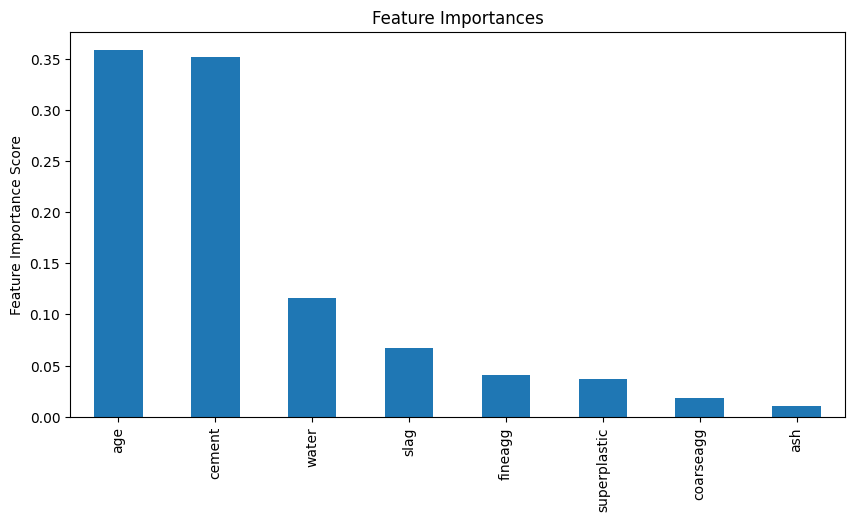

In [84]:
#Choose all predictors
plt.figure(figsize=(10,5))
modelfit(gbr, X_train, X_valid, X_test)

In [88]:
#Parameter tuning. Start with number of trees (n_estimators)
#Drop variables that are not significant as can be seen above (ash and coarseagg)

X=df.drop(['ash','coarseagg','strength','cluster'], axis=1).values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['ash','coarseagg','strength', 'cluster'], axis=1).columns

param_test1 = {'n_estimators':range(20,150,10)}
gsearch1 = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.1, min_samples_split=15, min_samples_leaf=15,
                                                            max_depth=8, max_features='sqrt', subsample=0.8, random_state=10),
                        param_grid=param_test1, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)

gs1=gsearch1.fit(X_train,y_train)
gs1.best_params_, gs1.best_score_

({'n_estimators': 110}, -31.408157335027447)

In [92]:
#N_estimators is best at 110. Fix n_estimator and tune for max_depth alongwith mi_samples_split

param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(10,100,10)}
gsearch2 = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.1, min_samples_leaf=15, n_estimators=110,
                                                            max_features='sqrt', subsample=0.8, random_state=10),
                        param_grid=param_test2, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)

gs2=gsearch2.fit(X_train,y_train)
gs2.best_params_, gs2.best_score_


({'max_depth': 13, 'min_samples_split': 10}, -31.6069315833975)


Model Report
Rsq (Train): 0.9669
Rsq (Validation): 0.898
Rsq (Test): 0.9021
MAPE (Train): 7.407520
MAPE (Valid): 12.164973
MAPE (Test): 13.490996
Correlation Coeff (Test): 0.951202
CV Score : Mean - -31.60693 | Std - 8.878783 | Min - -55.76213 | Max - -23.28964


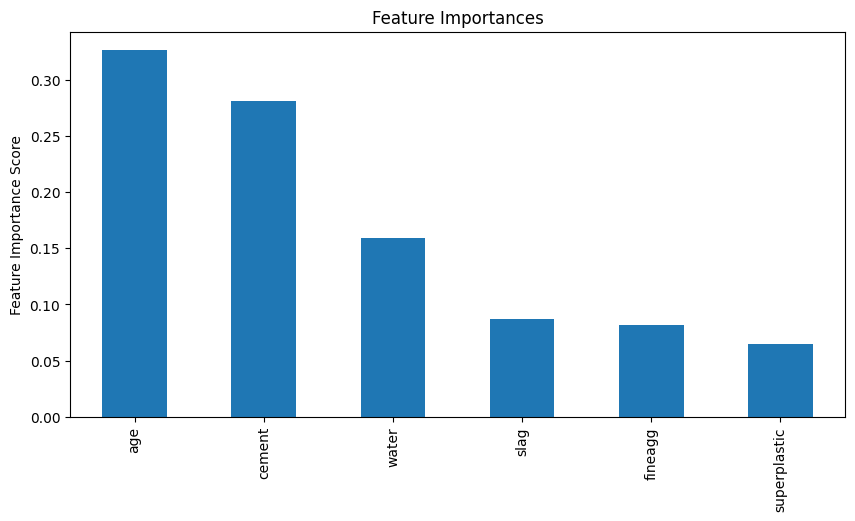

In [93]:
#replace maxdepth = 13 n min_samples_split=10. Check the performance
plt.figure(figsize=(10,5))
modelfit(gs2.best_estimator_,X_train, X_valid, X_test)

Text(0.5, 1.0, 'Actuals v Predicted')

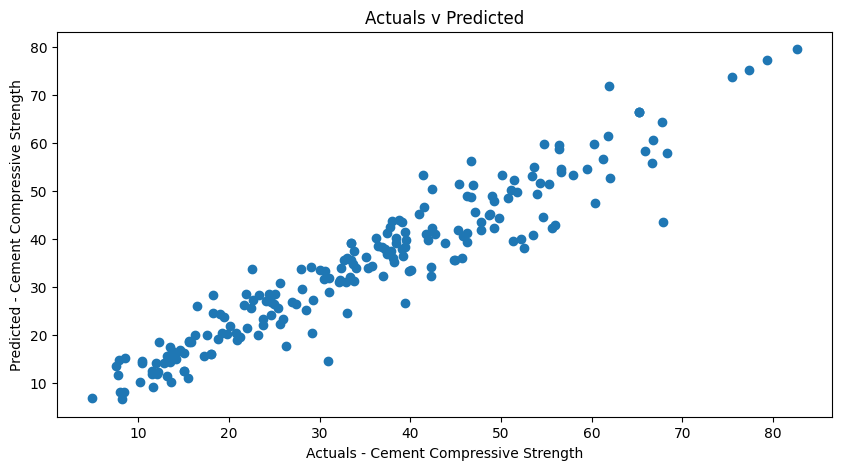

In [94]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, gs2.predict(X_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

In [97]:
# Now let's tune the last tree-parameters, i.e. max_features by trying values from 3 to 7 in steps of 1.
param_test3 = {'max_features': range(3, 7, 1)}

gsearch3 = GridSearchCV(
    estimator=GradientBoostingRegressor(
        learning_rate=0.1,
        min_samples_leaf=15,
        n_estimators=110,
        max_depth=13,
        subsample=0.8,
        random_state=10,
        min_samples_split=10
    ),
    param_grid=param_test3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=10
)

gs3 = gsearch3.fit(X_train, y_train)
gs3.best_params_, gs3.best_score_


({'max_features': 4}, -34.281053728629956)


Model Report
Rsq (Train): 0.9717
Rsq (Validation): 0.8927
Rsq (Test): 0.9024
MAPE (Train): 6.945807
MAPE (Valid): 12.584924
MAPE (Test): 12.877981
Correlation Coeff (Test): 0.950994
CV Score : Mean - -34.28105 | Std - 9.864216 | Min - -61.07602 | Max - -26.00206


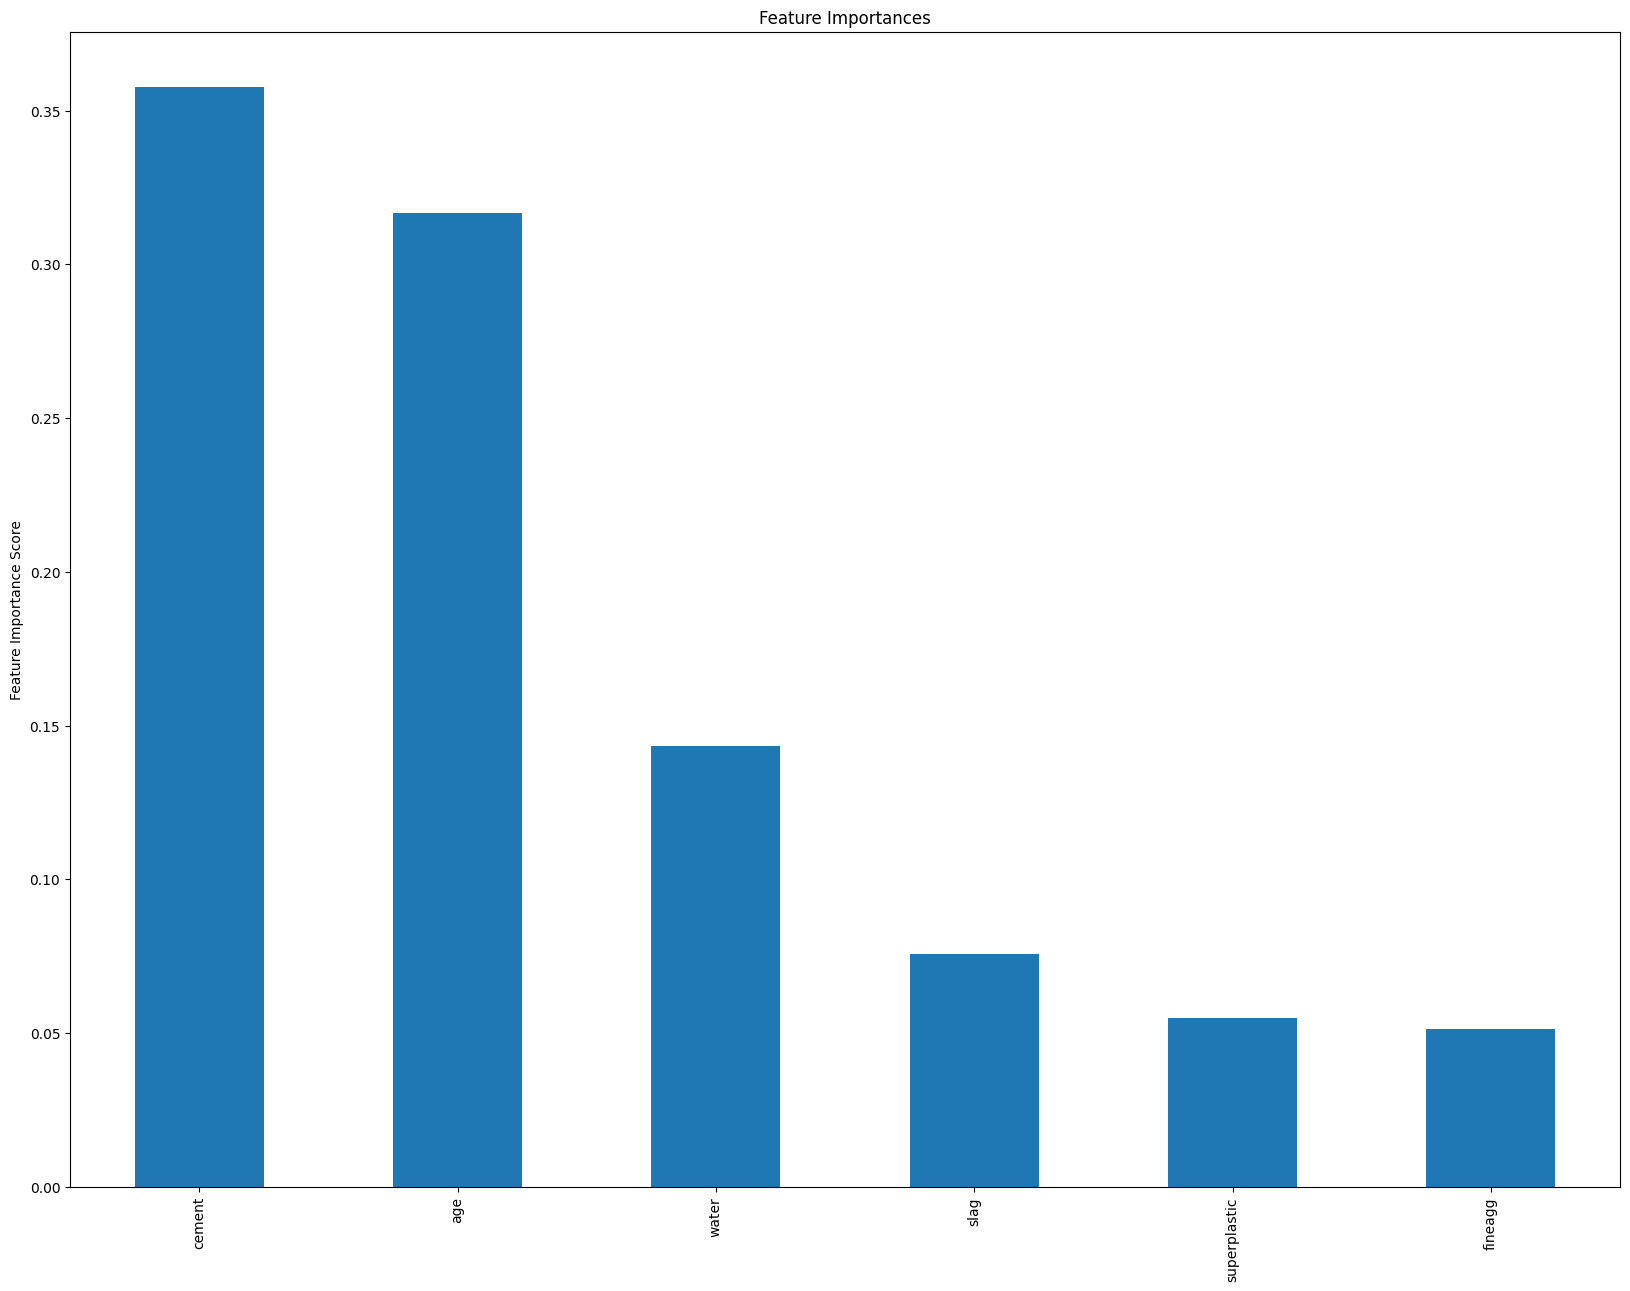

In [98]:
#replace max_features = 3 and Check the performance

modelfit(gs3.best_estimator_,X_train, X_valid, X_test)

In [99]:
#Slight improvement in performance is observed as can be seen by comparing the MAPE

Text(0.5, 1.0, 'Actuals v Predicted')

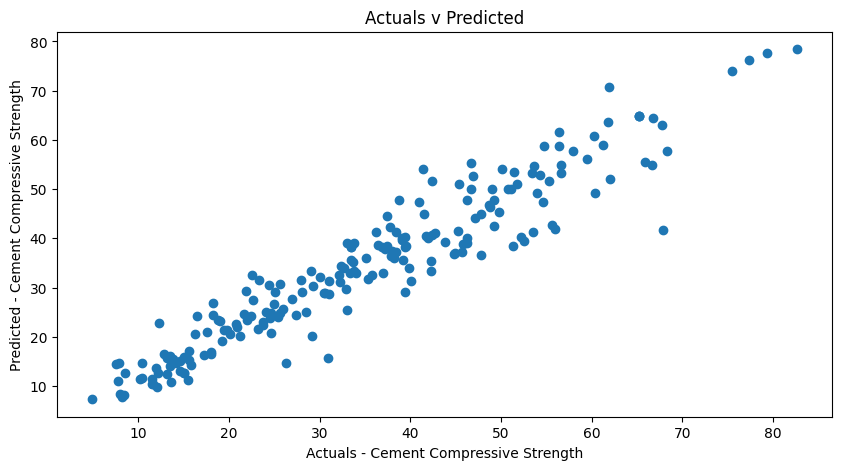

In [100]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, gs3.predict(X_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

In [103]:
# Tuning subsample and making models with a lower learning rate
param_test4 = {'subsample': [0.6, 0.85, 0.65, 0.7, 0.75, 0.8]}
gridsearch4 = GridSearchCV(
    estimator=GradientBoostingRegressor(
        learning_rate=0.1,
        min_samples_leaf=15,
        n_estimators=110,
        max_depth=13,
        random_state=10,
        min_samples_split=10,
        max_features=3
    ),
    param_grid=param_test4,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=10
)
gs4 = gridsearch4.fit(X_train, y_train)
gs4.best_params_, gs4.best_score_


({'subsample': 0.85}, -33.71417100796935)


Model Report
Rsq (Train): 0.9731
Rsq (Validation): 0.8997
Rsq (Test): 0.894
MAPE (Train): 6.638142
MAPE (Valid): 12.040191
MAPE (Test): 13.572533
Correlation Coeff (Test): 0.946788
CV Score : Mean - -33.71417 | Std - 11.42235 | Min - -66.29 | Max - -23.84813


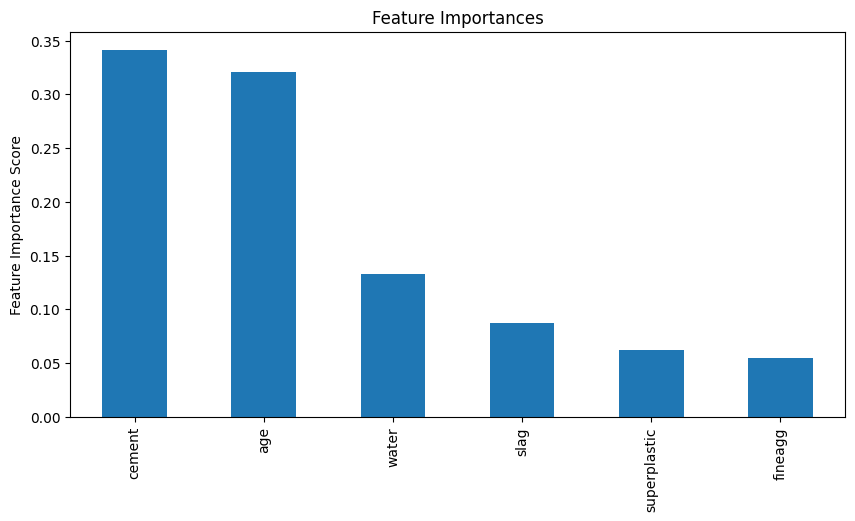

In [104]:
plt.figure(figsize=(10,5))
modelfit(gs4.best_estimator_, X_train, X_valid, X_test)


Model Report
Rsq (Train): 0.9743
Rsq (Validation): 0.8997
Rsq (Test): 0.9005
MAPE (Train): 6.511298
MAPE (Valid): 11.962350
MAPE (Test): 12.928388
Correlation Coeff (Test): 0.949985
CV Score : Mean - -33.71596 | Std - 10.03516 | Min - -61.31774 | Max - -26.0027


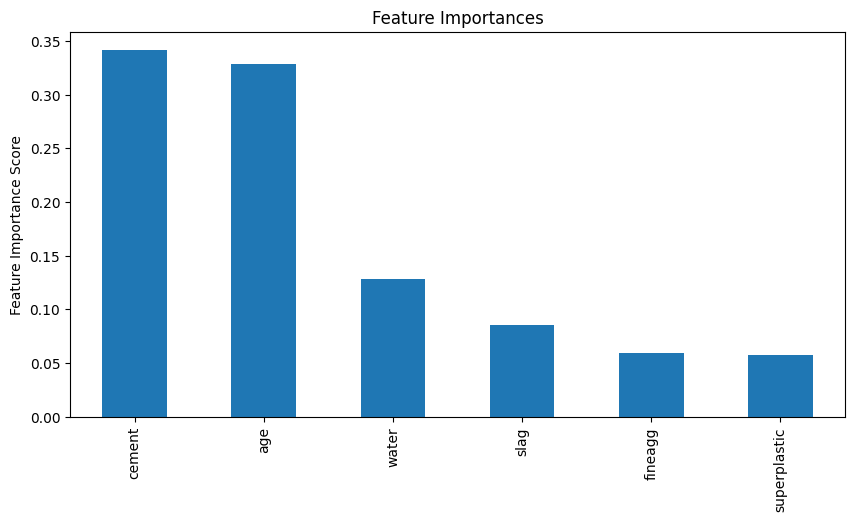

In [105]:
#Try lowering the learning rate and increase the number of trees simulataneously.

gbm_tuned= GradientBoostingRegressor(learning_rate=0.025,min_samples_leaf=15,n_estimators=440,
                                                               max_depth=13,random_state=10,min_samples_split=10,
                                                                max_features=3,subsample=0.85)
                                     
plt.figure(figsize=(10,5))
modelfit(gbm_tuned, X_train,X_valid, X_test)

Text(0.5, 1.0, 'Actuals v Predicted')

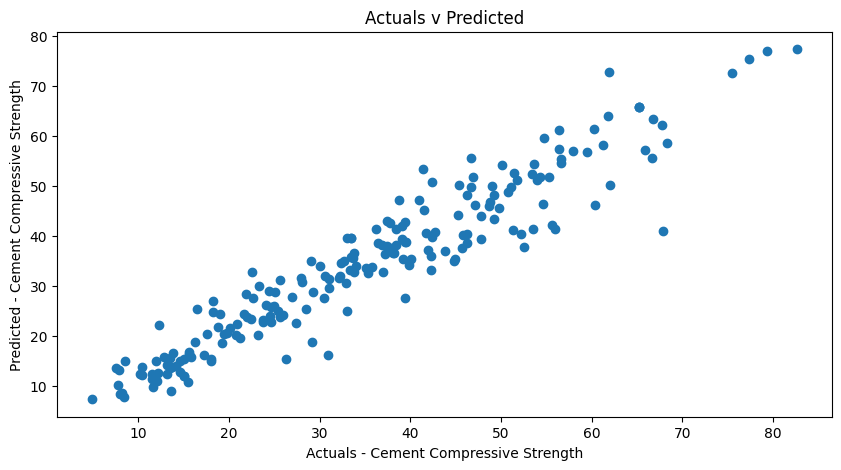

In [107]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, gbm_tuned.predict(X_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

#Best performance achieved with the tuned GBM model. However the model was trained and tuned on the original data. We saw that there is a non-linearship between X and Y.
Try the boosting model on transformed data

In [108]:
def modelfit(alg, dtrain,dvalid,dtest,performCV=True, printFeatureImportance=True, cv_folds=10):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)    
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)    
    #Predict valid set:
    dvalid_predictions = alg.predict(X_valid)    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)        
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error')
    
    #Print model report:
    print("\nModel Report")
    print("Rsq (Train): %.4g" % r2_score(y_train, dtrain_predictions))
    print("Rsq (Validation): %.4g" % r2_score(y_valid, dvalid_predictions))
    print("Rsq (Test): %.4g" % r2_score(y_test, dtest_predictions))
    print("MAPE (Train): %f" %mean_absolute_percentage_error(y_train, dtrain_predictions))
    print("MAPE (Valid): %f" %mean_absolute_percentage_error(y_valid, dvalid_predictions))
    print("MAPE (Test): %f" %mean_absolute_percentage_error(y_test, dtest_predictions))
    print("Correlation Coeff (Test): %f" %np.corrcoef(y_test,dtest_predictions)[0,1])
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))



modelfit(GradientBoostingRegressor(learning_rate=0.025,min_samples_leaf=15,n_estimators=440,
                                                               max_depth=13,random_state=10,min_samples_split=10,
                                                                max_features=3,subsample=0.85), X_train_tr,X_valid_tr, X_test)


Model Report
Rsq (Train): 0.9743
Rsq (Validation): 0.8997
Rsq (Test): 0.9005
MAPE (Train): 6.511298
MAPE (Valid): 11.962350
MAPE (Test): 12.928388
Correlation Coeff (Test): 0.949985
CV Score : Mean - -33.71596 | Std - 10.03516 | Min - -61.31774 | Max - -26.0027


In [109]:
#Almost identical results with higher dimensional tranformation of independent variables

# Random Forest with Tuning

In [110]:
#Lets try the random forest with tuning as above. Start with all predictors

X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['strength','cluster'] ,axis=1).columns
Rf_regressor1= RandomForestRegressor()
plt.figure(figsize=(10,5))
#Choose all predictors
modelfit(Rf_regressor1, X_train, X_valid, X_test)


Model Report
Rsq (Train): 0.9808
Rsq (Validation): 0.8433
Rsq (Test): 0.8535
MAPE (Train): 5.644240
MAPE (Valid): 15.142168
MAPE (Test): 15.659070
Correlation Coeff (Test): 0.925858
CV Score : Mean - -41.56757 | Std - 18.64097 | Min - -95.1653 | Max - -28.91887


<Figure size 1000x500 with 0 Axes>

In [112]:
# Parameter tuning starting with the number of trees along with Feature Selection

# Drop variables that are not significant as can be seen above (ash and coarseagg)
X = df.drop(['ash', 'coarseagg', 'strength', 'cluster'], axis=1).values
y = df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors = df.drop(['ash', 'coarseagg', 'strength', 'cluster'], axis=1).columns

param_test1 = {'n_estimators': range(20, 150, 10)}
gsearch1 = GridSearchCV(
    estimator=RandomForestRegressor(
        min_samples_split=15,
        min_samples_leaf=15,
        max_depth=8,
        max_features='sqrt',
        random_state=10
    ),
    param_grid=param_test1,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=10
)
gs1 = gsearch1.fit(X_train, y_train)
gs1.best_params_, gs1.best_score_


({'n_estimators': 80}, -91.90154984366649)

In [124]:
param_test2 = {'max_depth': range(4, 16, 2), 'min_samples_split': range(10, 100, 10)}
gsearch2 = GridSearchCV(estimator=RandomForestRegressor(min_samples_leaf=15, n_estimators=80, max_features='sqrt', random_state=10),
                        param_grid=param_test2, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
gs2 = gsearch2.fit(X_train, y_train)
gs2.best_params_, gs2.best_score_


({'max_depth': 8, 'min_samples_split': 10}, -91.90154984366649)

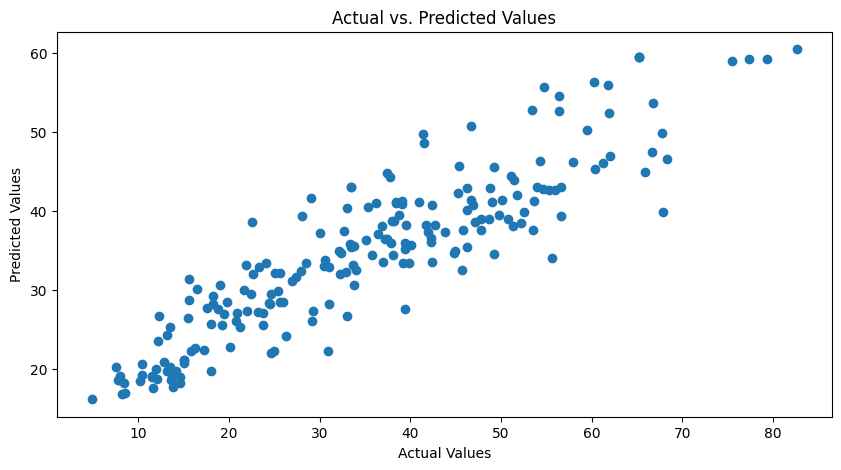

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np

def plot_actual_vs_predicted(model, X_test, y_test):
    y_pred = model.predict(X_test)

    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.show()

# Assuming gs2 is your best model
best_model = gs2.best_estimator_

# Plot actual vs. predicted values
plot_actual_vs_predicted(best_model, X_test, y_test)


In [129]:
# Now let's tune the last tree-parameters, i.e., max_features and min_samples_leaf
param_test3 = {'max_features': range(3, 7, 1), 'min_samples_leaf': range(10, 100, 10)}

gsearch3 = GridSearchCV(
    estimator=RandomForestRegressor(
        n_estimators=80,
        max_depth=8,
        random_state=10,
        min_samples_split=10
    ),
    param_grid=param_test3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=10
)
gs3 = gsearch3.fit(X_train, y_train)
gs3.best_params_, gs3.best_score_


({'max_features': 4, 'min_samples_leaf': 10}, -61.701190765964085)

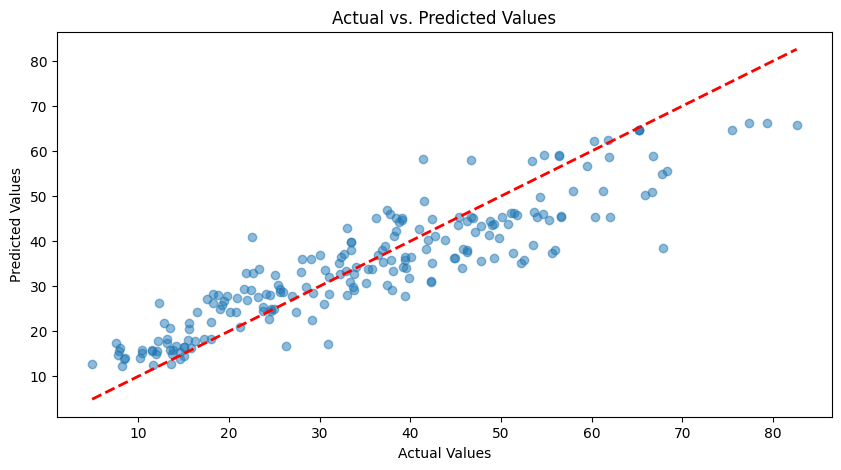

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np

def plot_actual_vs_predicted(model, X_test, y_test):
    y_pred = model.predict(X_test)

    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', linewidth=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.show()

# Assuming gs3 is your best model
best_model = gs3.best_estimator_

# Plot actual vs. predicted values
plot_actual_vs_predicted(best_model, X_test, y_test)


#The best results were achieved without any tuning and feature selection with the random forest regressor. Let's put the removed variables back to compare performace

In [132]:
X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['strength','cluster'] ,axis=1).columns
Rf_regressor= RandomForestRegressor(n_estimators=80,max_depth=8,random_state=10, min_samples_split=10, max_features=4,
                                   min_samples_leaf=10)
plt.figure(figsize=(10,5))
#Choose all predictors
modelfit(Rf_regressor, X_train, X_valid, X_test)


Model Report
Rsq (Train): 0.8404
Rsq (Validation): 0.7633
Rsq (Test): 0.7981
MAPE (Train): 19.486276
MAPE (Valid): 22.775749
MAPE (Test): 22.916583
Correlation Coeff (Test): 0.909193
CV Score : Mean - -65.12647 | Std - 21.68684 | Min - -119.3547 | Max - -42.99047


<Figure size 1000x500 with 0 Axes>

#The random forest regressor without any feature selection and any tuning gave the best results amongst all random forest models build. The tuned boosting model though has given the best results.

Text(0.5, 1.0, 'Actuals v Predicted')

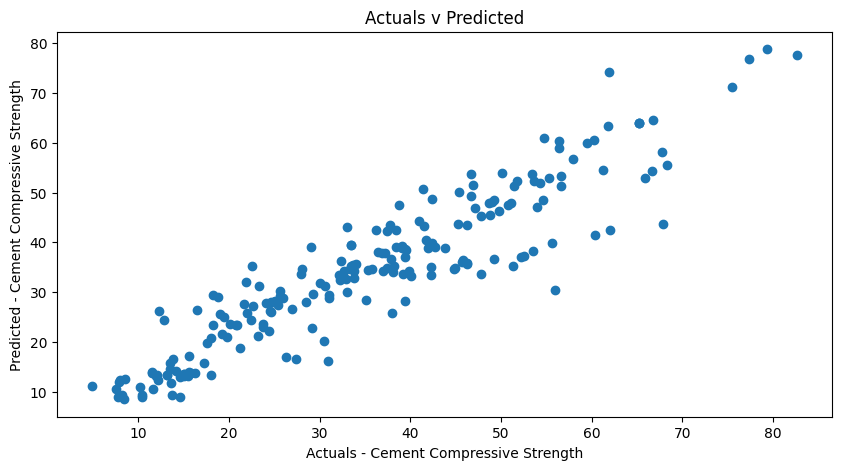

In [133]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, Rf_regressor1.predict(X_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

# Try XGBoost with Tuning

In [134]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['strength','cluster'], axis=1).columns
Xgb_regressor= XGBRegressor()

In [135]:
def modelfit(alg, dtrain,dvalid,dtest ,predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='rmse')
    
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    
    #Predict valid set:
    dvalid_predictions = alg.predict(X_valid)
    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)
        
        
    #Print model report:
    print ("\nModel Report")
    print("Rsq (Train): %.4g" % r2_score(y_train, dtrain_predictions))
    print("Rsq (Validation): %.4g" % r2_score(y_valid, dvalid_predictions))
    print("Rsq (Test): %.4g" % r2_score(y_test, dtest_predictions))
    print("MAPE (Train): %f" %mean_absolute_percentage_error(y_train, dtrain_predictions))
    print("MAPE (Valid): %f" %mean_absolute_percentage_error(y_valid, dvalid_predictions))
    print("MAPE (Test): %f" %mean_absolute_percentage_error(y_test, dtest_predictions))
    print("Correlation Coeff (Test): %f" %np.corrcoef(y_test,dtest_predictions)[0,1])

In [136]:
#In order to decide on boosting parameters, we need to set some initial values of other parameters.

xgb1 = XGBRegressor(booster='gbtree',
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train, X_valid, X_test,predictors)


Model Report
Rsq (Train): 0.9987
Rsq (Validation): 0.8776
Rsq (Test): 0.8869
MAPE (Train): 1.343086
MAPE (Valid): 12.098416
MAPE (Test): 12.716737
Correlation Coeff (Test): 0.943620


In [140]:
# Tune max_depth and min_child_weight
param_test1 = {
    'max_depth': range(3, 8, 1),
    'min_child_weight': range(1, 6, 1)
}

gsearch1 = GridSearchCV(
    estimator=XGBRegressor(
        booster='gbtree',
        learning_rate=0.1,
        n_estimators=100,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        nthread=4,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test1,
    scoring='neg_mean_squared_error',
    n_jobs=4,
    cv=5
)

gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_


({'max_depth': 4, 'min_child_weight': 2}, -33.94420007161039)

In [141]:
modelfit(gsearch1.best_estimator_, X_train,X_valid,X_test, predictors)


Model Report
Rsq (Train): 0.9765
Rsq (Validation): 0.8796
Rsq (Test): 0.8844
MAPE (Train): 6.487606
MAPE (Valid): 12.859514
MAPE (Test): 14.227522
Correlation Coeff (Test): 0.942937


In [172]:
# Tune gamma
param_test2 = {
    'gamma': [i/10.0 for i in range(0, 5)]
}

gsearch2 = GridSearchCV(
    estimator=XGBRegressor(
        booster='gbtree',
        learning_rate=0.1,
        n_estimators=100,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        nthread=4,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test2,
    scoring='neg_mean_squared_error',
    n_jobs=4,
    cv=5
)
gsearch2.fit(X_train, y_train)
gsearch2.best_params_, gsearch2.best_score_


({'gamma': 0.3}, -21.82149336384232)

In [185]:
# Tune subsample and colsample_bytree
param_test3 = {
    'subsample': [i/10.0 for i in range(6, 10)],
    'colsample_bytree': [i/10.0 for i in range(6, 10)]
}

gsearch3 = GridSearchCV(
    estimator=XGBRegressor(
        booster='gbtree',
        learning_rate=0.1,
        n_estimators=100,
        max_depth=4,
        gamma=0,
        min_child_weight=1,
        nthread=4,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test3,
    scoring='neg_mean_squared_error',
    n_jobs=4,
    cv=5
)

gsearch3.fit(X_train, y_train)
gsearch3.best_params_, gsearch3.best_score_


({'colsample_bytree': 0.8, 'subsample': 0.8}, -21.89010754272872)

In [186]:
# Tuning Regularization Parameters
param_test4 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

gsearch4 = GridSearchCV(
    estimator=XGBRegressor(
        booster='gbtree',
        learning_rate=0.1,
        n_estimators=100,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        gamma=0,
        nthread=4,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test4,
    scoring='neg_mean_squared_error',
    n_jobs=4,
    cv=5
)

gsearch4.fit(X_train, y_train)
gsearch4.best_params_, gsearch4.best_score_
def modelfit(alg, dtrain, dvalid, dtest, predictors):
    # Check if 'target' column exists in the data frames
    if 'target' not in dtrain.columns or 'target' not in dvalid.columns or 'target' not in dtest.columns:
        raise ValueError("Column 'target' not found in one of the data frames.")

    # Check if all predictors are present in the data frames
    missing_predictors = set(predictors) - set(dtrain.columns)
    if missing_predictors:
        raise ValueError(f"Predictors {missing_predictors} not found in the data frames.")

    alg.fit(dtrain[predictors], dtrain['target'])

    dvalid_predictions = alg.predict(dvalid[predictors])
    dtest_predictions = alg.predict(dtest[predictors])

    # ... (rest of the function remains unchanged)


In [187]:
def modelfit(alg, dtrain, dvalid, dtest, predictors):
    # Check if 'target' column exists in the data frames
    if 'target' not in dtrain.columns or 'target' not in dvalid.columns or 'target' not in dtest.columns:
        raise ValueError("Column 'target' not found in one of the data frames.")

    # Check if all predictors are present in the data frames
    missing_predictors = set(predictors) - set(dtrain.columns)
    if missing_predictors:
        raise ValueError(f"Predictors {missing_predictors} not found in the data frames.")

    alg.fit(dtrain[predictors], dtrain['target'])

    dvalid_predictions = alg.predict(dvalid[predictors])
    dtest_predictions = alg.predict(dtest[predictors])

    # ... (rest of the function remains unchanged)


In [188]:
param_test5 = {
    'reg_alpha': [0.07, 0.08, 0.09, 0.1, 0.11, 0.12]
}

gsearch5 = GridSearchCV(
    estimator=XGBRegressor(
        booster='gbtree',
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        gamma=0,
        nthread=4,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test5,
    scoring='neg_mean_squared_error',
    n_jobs=4,
    cv=5
)

gsearch5.fit(X_train, y_train)
gsearch5.best_params_, gsearch5.best_score_


({'reg_alpha': 0.07}, -18.665597466810716)

In [ ]:
# Since the first XGB model produced the least MAPE, we could try Reducing Learning Rate for the first model and double the no. of estimators

XGB=XGBRegressor( booster='gbtree', learning_rate =0.05, n_estimators=2000,
 max_depth=4, subsample=0.8, colsample_bytree=0.8,min_child_weight=1,gamma=0,
 nthread=4, scale_pos_weight=1,reg_alpha=0.1 ,seed=27)

modelfit(XGB, X_train,X_valid, X_test, predictors)

The best results are achieved through the fully tuned gbm model and the XGB model above. XGB gives slightly better results but the computation time is a little more. Any of the two models can be used in production

In [190]:
#Try Support Vector Machine
X=df.drop(['strength','cluster'], axis=1).values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['strength', 'cluster'], axis=1).columns

In [191]:
def modelfit(alg, dtrain,dvalid,dtest,performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)    
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)    
    #Predict valid set:
    dvalid_predictions = alg.predict(X_valid)    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)        
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error')
    
    #Print model report:
    print("\nModel Report")
    print("Rsq (Train): %.4g" % r2_score(y_train, dtrain_predictions))
    print("Rsq (Validation): %.4g" % r2_score(y_valid, dvalid_predictions))
    print("Rsq (Test): %.4g" % r2_score(y_test, dtest_predictions))
    print("MAPE (Train): %f" %mean_absolute_percentage_error(y_train, dtrain_predictions))
    print("MAPE (Valid): %f" %mean_absolute_percentage_error(y_valid, dvalid_predictions))
    print("MAPE (Test): %f" %mean_absolute_percentage_error(y_test, dtest_predictions))
    print("Correlation Coeff (Test): %f" %np.corrcoef(y_test,dtest_predictions)[0,1])
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [192]:
param_grid = {'kernel': ['rbf', 'sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [0.1, 10, 25]}
gsearch1 = GridSearchCV(estimator=SVR(), param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
gs1 = gsearch1.fit(X_train, y_train)
print(gs1.best_params_, gs1.best_score_)


{'C': 25, 'gamma': 0.0001, 'kernel': 'rbf'} -72.61380735805264


In [193]:
param_grid = {'kernel': ['rbf'], 'gamma': [0.0001, 0.000025, 0.0000125, 0.0000125/2, 0.0000125/4],
              'C': [750, 1000, 1150, 1175, 1200, 1225]}

gsearch2 = GridSearchCV(estimator=SVR(), param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
gs2 = gsearch2.fit(X_train, y_train)
print(gs2.best_params_, gs2.best_score_)

print("Correlation_Validation:", np.corrcoef(y_valid, gs2.predict(X_valid))[0, 1])
print("Correlation_Test:", np.corrcoef(y_test, gs2.predict(X_test))[0, 1])

Rsq_valid = r2_score(y_valid, gs2.predict(X_valid))
Rsq_test = r2_score(y_test, gs2.predict(X_test))

Rsq_Adj_valid = 1 - (((1 - Rsq_valid**2) * (n_valid - 1)) / (n_valid - k - 1))
print('Rsq_Adj_valid:%.2f' % Rsq_Adj_valid)

Rsq_Adj_test = 1 - (((1 - Rsq_test**2) * (n_test - 1)) / (n_test - k - 1))
print('Rsq_Adj_test:%.2f' % Rsq_Adj_test)

MAPE_Test = mean_absolute_percentage_error(y_test, gs2.predict(X_test))
print('MAPE_SVR:%.2f' % MAPE_Test)


{'C': 1200, 'gamma': 1.25e-05, 'kernel': 'rbf'} -37.397303174235965
Correlation_Validation: 0.9207407480179896
Correlation_Test: 0.9176778159765036
Rsq_Adj_valid:0.71
Rsq_Adj_test:0.69
MAPE_SVR:16.43


In [194]:
#With Multiple iterations of the rbf kernel grid search, the best model achieved is with the above hyperparameters

In [195]:
#Try stacking
from vecstack import stacking


models = [
    GradientBoostingRegressor(learning_rate=0.025,min_samples_leaf=15,n_estimators=440,max_depth=13,random_state=10,
                              min_samples_split=10,max_features=3,subsample=0.85),
        
    RandomForestRegressor(),
        
    XGBRegressor(booster='gbtree', learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27),
    gsearch2.best_estimator_ , #Support Vector Regressor
    Las_gs.best_estimator_ #Lasso model tried earlier
            
]

In [196]:
from vecstack import stacking

X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)

S_train, S_test = stacking(models,                   
                           X_train, y_train, X_test,   
                           regression=True,      
                           mode='oof_pred_bag',       
                           needs_proba=False,         
                           save_dir=None,            
                           metric='neg_mean_squared_error',     
                           n_folds=10,                 
                           shuffle=True,            
                           random_state=0,         
                           )

In [197]:
#The beta model is below

model = Ridge()

model = model.fit(S_train, y_train)


Rsq_test=r2_score(y_test,model.predict(S_test))


Rsq_Adj_valid= 1- (((1-Rsq_valid**2)*(n_valid-1))/(n_valid-k-1))
print('Rsq_Adj_valid:%.2f'%Rsq_Adj_valid)

#Rsq_Adj= 1- [(1-Rsq^2)*(n-1)/(n-k-1)]
Rsq_Adj_test= 1- (((1-Rsq_test**2)*(n_test-1))/(n_test-k-1))
print('Rsq_Adj_test:%.2f'%Rsq_Adj_test)


MAPE_Test=mean_absolute_percentage_error(y_test,model.predict(S_test))
print('MAPE_stackedModels:%.2f' %MAPE_Test)

Rsq_Adj_valid:0.71
Rsq_Adj_test:0.88
MAPE_stackedModels:9.01


Text(0.5, 1.0, 'Actuals v Predicted')

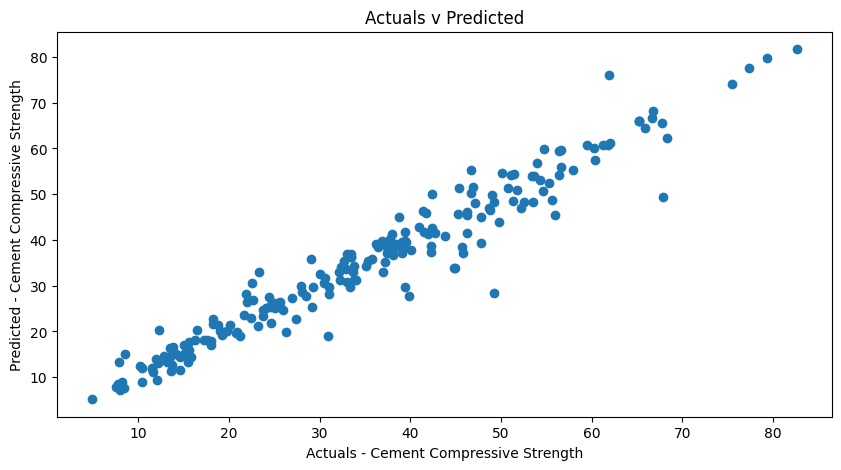

In [199]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, model.predict(S_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")